In [17]:
import functools

import numpy as np

import jax
import jax.numpy as jnp
import jax.nn as jnn
import haiku as hk
import distrax

import sinusoid_regression_dataset
import pacoh_nn as pacoh

## Setting up the dataset and prediction function


In [18]:
dataset = sinusoid_regression_dataset.SinusoidRegression(16, 5, 5)

def net(x):
    x = hk.nets.MLP((32, 32, 32, 32, 1))(x)
    mu = x
    stddev = hk.get_parameter("stddev", [], init=lambda shape, dtype: jnp.ones(shape, dtype) * 1e-3)
    return mu, stddev * jnp.ones_like(mu)

## Plotting

In [19]:
import matplotlib.pyplot as plt


def plot(x, y, x_tst, y_tst, yhats):
    mus, stddevs = yhats
    plt.figure(figsize=(10, 5))  # inches
    for task in range(6):
        plt.subplot(2, 3, task + 1)
        plt.plot(x[task], y[task], "b.", label="observed")
        avgm = np.zeros_like(x_tst[task, :, 0])
        for i, (mu, stddev) in enumerate(zip(mus[task], stddevs[task])):
            m = np.squeeze(mu)
            s = np.squeeze(stddev)
            if i < 15:
                plt.plot(
                    x_tst[task],
                    m,
                    "r",
                    label="ensemble means" if i == 0 else None,
                    linewidth=1.0,
                )
                plt.plot(
                    x_tst[task],
                    m + 3 * s,
                    "g",
                    linewidth=0.5,
                    label="ensemble means + 3 ensemble stdev" if i == 0 else None,
                )
                plt.plot(
                    x_tst[task],
                    m - 3 * s,
                    "g",
                    linewidth=0.5,
                    label="ensemble means - 3 ensemble stdev" if i == 0 else None,
                )
            avgm += m
        plt.plot(
            x_tst[task], avgm / (i + 1), "r", label="overall mean", linewidth=4
        )
        plt.plot(
            x_tst[task], y_tst[task], "b", label="overall mean", linewidth=1
        )
        ax = plt.gca()
        ax.xaxis.set_ticks_position("bottom")
        ax.yaxis.set_ticks_position("left")
        ax.spines["left"].set_position(("data", 0))
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    plt.tight_layout()

## Setting up the model

In [20]:
import models
import optax

init, apply = hk.without_apply_rng(hk.transform(net))
example = next(dataset.train_set)[0][0]
seed_sequence = hk.PRNGSequence(666)
mean_prior_over_mus = jax.tree_map(
    jnp.zeros_like, init(next(seed_sequence), example)
)
mean_prior_over_stddevs = jax.tree_map(jnp.zeros_like, mean_prior_over_mus)
hyper_prior = models.ParamsMeanField(
    models.ParamsMeanField(mean_prior_over_mus, mean_prior_over_stddevs),
    0.5,
)
n_particles = 10
init = jax.vmap(init, (0, None))
particles_mus = init(jnp.asarray(seed_sequence.take(n_particles)), example)
particle_stddevs = jax.tree_map(lambda x: jnp.ones_like(x) * 1e-4, particles_mus)
hyper_posterior = models.ParamsMeanField(particles_mus, particle_stddevs)

/home/yarden/miniconda3/envs/jax-ml/lib/python3.10/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


## Training a model sampled from the hyper-posterior: 100 examples
The first sanity check is to make sure that the model is able to fit different sinusoid functions when enough examples are given.

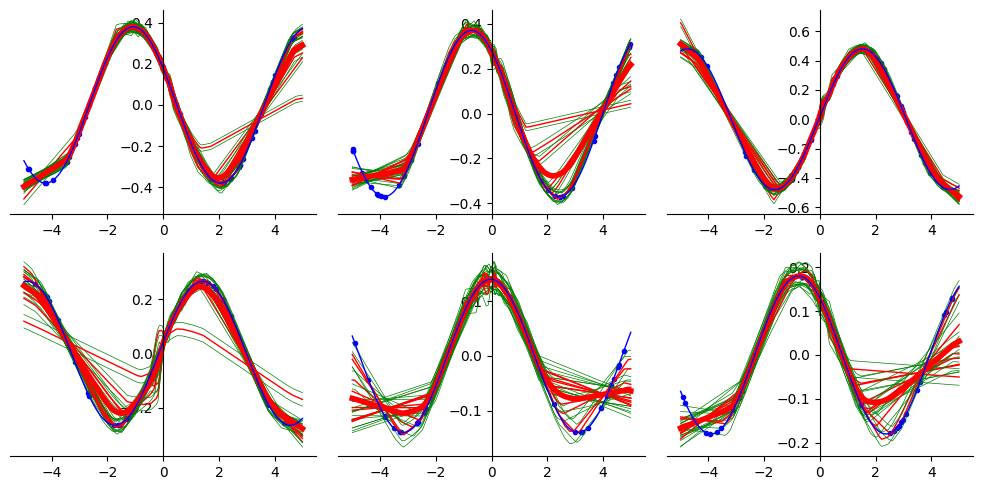

In [21]:
easy_dataset = sinusoid_regression_dataset.SinusoidRegression(16, 5, 50)

infer_posteriors = jax.vmap(
    pacoh.infer_posterior, in_axes=(0, 0, None, None, None, None, None)
)

(context_x, context_y), (test_x, test_y) = next(easy_dataset.test_set)
posteriors, losses = infer_posteriors(
    context_x, context_y, hyper_posterior, apply, next(seed_sequence), 1000, 3e-4
)
predict = jax.vmap(pacoh.predict, (0, 0, None))
predictions = predict(posteriors, test_x, apply)
plot(context_x, context_y, test_x, test_y, predictions)

As seen, we're generally able to fit the ensembles to most of the tasks when we're given 100 samples to learn from

## Training a model sampled from the hyper-prior
Now let's see what happens if our model is given only a _small_ number of samples (5, to be exact)

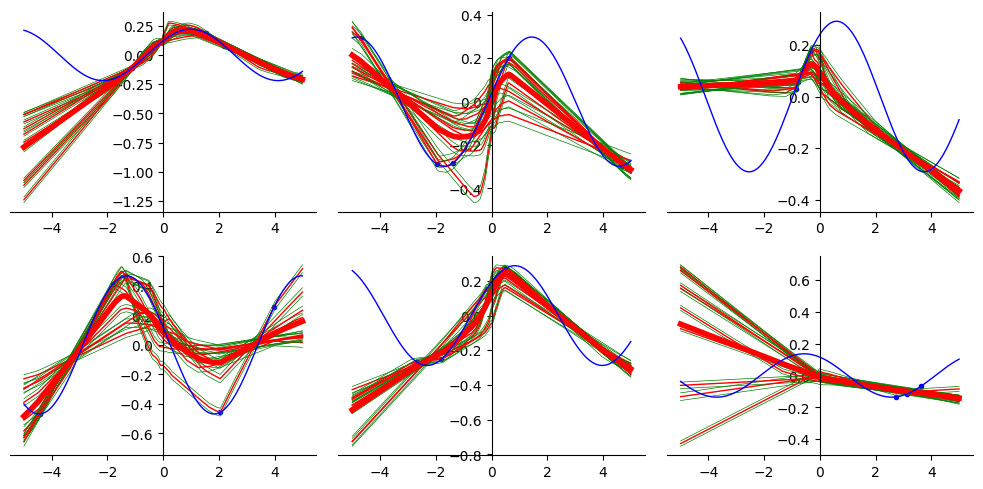

In [22]:
(context_x, context_y), (test_x, test_y) = next(dataset.test_set)
posteriors, losses = infer_posteriors(
    context_x, context_y, hyper_posterior, apply, next(seed_sequence), 1000, 3e-4
)
predictions = predict(posteriors, test_x, apply)
plot(context_x, context_y, test_x, test_y, predictions)

As shown, when the model is given only 5 examples per task, it gloriously fails to fit the data well.

## Meta-training

In [23]:

opt = optax.flatten(optax.adam(3e-4))
opt_state = opt.init(hyper_posterior)
hyper_posterior = pacoh.meta_train(
    dataset.train_set, apply, hyper_prior, hyper_posterior, opt, opt_state, 1000, 10
)


Iteration 0 log probs: 116483.6171875
Iteration 100 log probs: 2217.718505859375
Iteration 200 log probs: 1944.2088623046875
Iteration 300 log probs: 1850.2410888671875
Iteration 400 log probs: 1905.4891357421875
Iteration 500 log probs: 1873.564697265625
Iteration 600 log probs: 1796.0650634765625
Iteration 700 log probs: 1931.8763427734375
Iteration 800 log probs: 1734.9554443359375
Iteration 900 log probs: 1753.8291015625


## Prediction with Prior

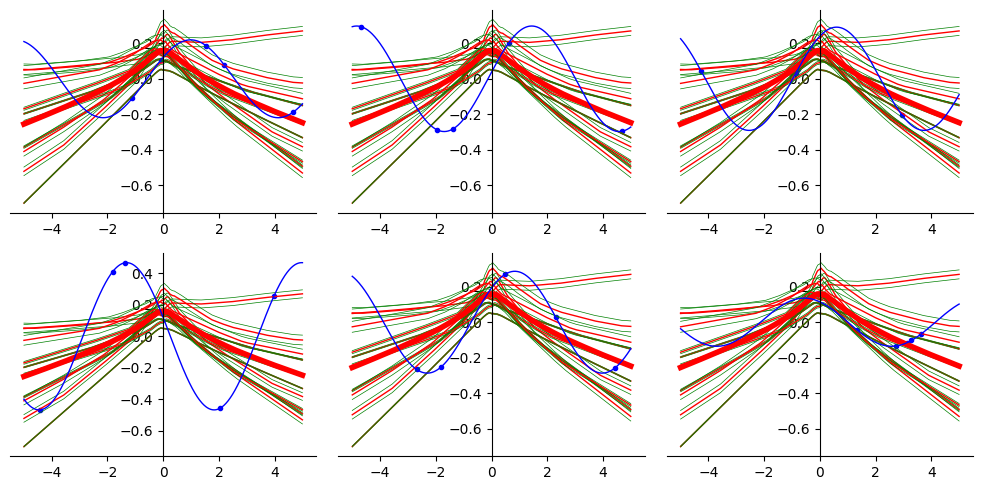

In [24]:
posteriors, losses = infer_posteriors(
    context_x, context_y, hyper_posterior, apply, next(seed_sequence), 0, 0.
)
predictions = predict(posteriors, test_x, apply)
plot(context_x, context_y, test_x, test_y, predictions)

## Posterior(s) Inference & Predicition

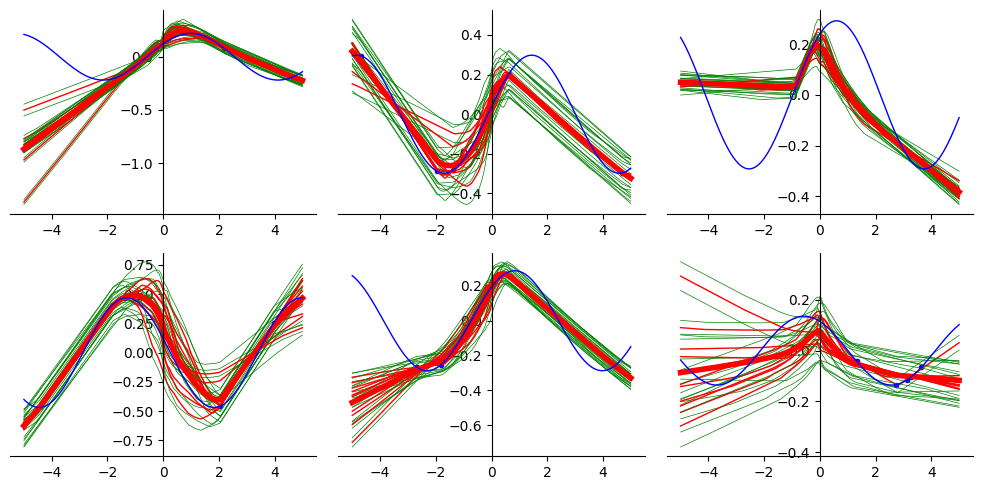

In [25]:

posteriors, losses = infer_posteriors(
    context_x, context_y, hyper_posterior, apply, next(seed_sequence), 1000, 3e-4
)
predictions = predict(posteriors, test_x, apply)
plot(context_x, context_y, test_x, test_y, predictions)